In [27]:
!pip install seaborn


   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   --------------- ------------------------ 112.6/294.6 kB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 4.6 MB/s eta 0:00:00


In [236]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")


In [237]:
#DATA CLEANING

from car.constant import color_mapping, prefecture_names

'''
Since data are taken from a japanese used car website, most of them contains japanese character, 
and they put the car name together with some specs that come with the car eg: 'Daihatsu Tanto 4WD with seat heater'.
We will clean this data into a more understandable format and can be used by many people
'''
cars_df = pd.read_csv("japan_used_cars.csv").drop(columns="Unnamed: 0", axis=1)

# Change maker name into readable format
maker_japanese = ['ダイハツ', '三菱', 'スズキ', 'ホンダ', '日産', 'マツダ', 'スバル', 'トヨタ']

maker_english = ["Daihatsu","Mitsubishi","Suzuki","Honda","Nissan","Mazda","Subaru","Toyota"]

maker_dict = {k:v for k,v in zip(maker_japanese,maker_english)} #Create dict of unique car maker

cars_df["maker"] = cars_df["maker"].replace(maker_dict)

"""
Car name comes with a few option that car has; 4WD:4wheel drive, RS:Racing Sport or turbo and hybrid.
We can consider car with RS option has turbo as they are equiped with racing spec, but not all turbo is RS.
"""
# Set our condition
conditions = [
    cars_df["car_name"].str.contains("RS"),
    cars_df["car_name"].str.contains("4W"),
    cars_df["car_name"].str.contains("ターボ"),
]

choices = [
    "RS","4WD","Turbo"
]

cars_df = cars_df.assign(
    name = cars_df["car_name"].str.split().str[0],
    spec = np.select(conditions, choices, default="2WD")
).drop(columns="car_name", axis=1)

# Change prices and base price to int, these values in japanes yen, value of x10000yen, eg: 94.9 = 949,000yen
change_type = {
    "prices":"float",
    "base_price":"float",
}
cars_df = cars_df.astype(change_type)

# Change trim type
trim_japanese = ['ハッチバック', 'クロカン・ＳＵＶ', 'トラック', 'オープン', 'ステーションワゴン']
trim_english = ["hatchback", "cross-country/SUV", "truck", "open-car", "station-wagon"]
cars_df["trim"] = cars_df["trim"].replace({k:v for k,v in zip(trim_japanese,trim_english)})

# Change color to english, used help from chatgpt tp help me translate.

cars_df["color"] = cars_df["color"].replace(color_mapping)

# Remove km from each milage, and 万 means, 10000km, so we will multiply milage with that symbol
cars_df["milage"] = cars_df["milage"].str[:-2]
cars_df["milage"] = np.where(cars_df["milage"].str.contains("万"), 
                            cars_df["milage"].str.replace("万","").astype(float)*10000,
                            cars_df["milage"].str.replace("万","").astype(float))

cars_df["permit_validity"].unique()

choices_permit = [
    "Permit extension service",
    "No permit extension service",
    "New car (3years)",
    cars_df["permit_validity"].map(lambda x : x[:4] + x[-3:-1])
]
conditions_permit = [
    cars_df["permit_validity"] == "車検整備付",
    cars_df["permit_validity"] == "車検整備無",
    cars_df["permit_validity"] == "新車未登録",
    (~cars_df["permit_validity"].isin(choices_permit[:2])),
]

cars_df["permit_validity"] = np.select(conditions_permit,choices_permit,default=cars_df["permit_validity"])
# mask = (~cars_df["permit_validity"].isin(choices_permit))

cars_df["repair_history"] = cars_df["repair_history"].replace({"なし":"No","あり":"Yes"})
cars_df["guarantee"] = cars_df["guarantee"].replace({"保証付":"Guarantee","保証無":"No Guarante"})

df = cars_df.drop(columns="city", axis=1)

rename= ['maker', 'name','base_price','prices','spec', 'year',"score",
       'prefecture','trim','milage', 'color','permit_validity',
       'repair_history', 'guarantee', 'engine_size']
df = df.loc[:, rename]
df["prefecture"] = df["prefecture"].replace(prefecture_names)

bins = np.linspace(1,5,9)
labeles = ["1.0-1.5", "1.5-2.0", "2.0-2.5", "2.5-3.0", "3.0-3.5","3.5-4.0","4.0-4.5","4.5-5.0"]
df["score_cat"] = pd.cut(df["score"], labels=labeles, bins=bins)



In [238]:
#DATA ANALYSIS => DISTRIBUTION OF NUMERICAL DATA
df.loc[:,["base_price","prices","milage","score"]].describe()

,base_price,prices,milage,score
count,1500.000000,1500.000000,1500.000000,1418.000000
mean,90.489267,98.933133,31106.778000,4.755007
std,36.086213,35.988637,25675.596988,0.214390
min,19.000000,27.900000,2.000000,1.000000
25%,63.000000,71.975000,9000.000000,4.700000
50%,89.000000,97.000000,26000.000000,4.800000
75%,112.775000,119.950000,48000.000000,4.900000
max,245.800000,252.300000,124000.000000,5.000000


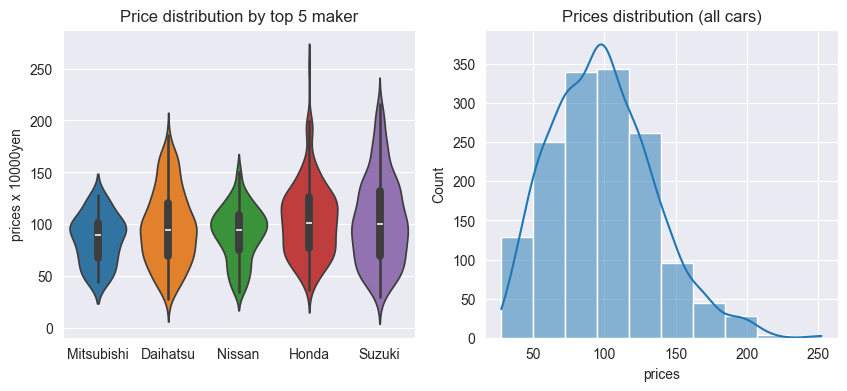

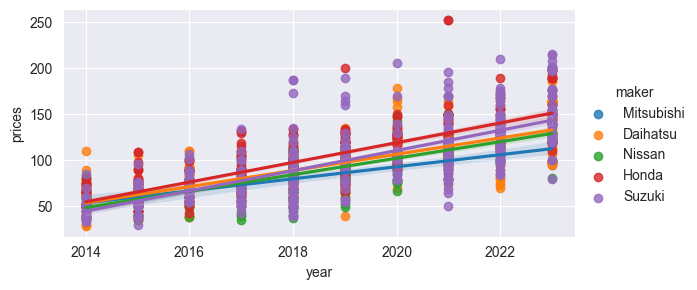

In [239]:
# Distribution of top 5 maker

top5_maker = df["maker"].value_counts()[:5].index.to_list()

fig, axes = plt.subplots(1,2,figsize=(10,4))
axes = axes.ravel()

sns.violinplot(
    data=df.loc[df["maker"].isin(top5_maker)],
    y="prices",
    x="maker",
    ax=axes[0],
    hue="maker"
)
axes[0].set_title("Price distribution by top 5 maker")
axes[0].set_ylabel("prices x 10000yen")
axes[0].set_xlabel("")

sns.histplot(
    data=df["prices"],
    bins=10,
    ax=axes[1],
    kde=True
)
axes[1].set_title("Prices distribution (all cars)")

sns.lmplot(
    data=df.loc[df["maker"].isin(top5_maker)],
    x="year",
    y="prices",
    hue="maker",
    height=3,
    aspect=2
)

# Most daihatsu car is lower than average price while other makers are almost the same 
# most car prices ranges arount 500,000 to 1,500,000 yen
# It is obvious that the newer the cars, the higher they cost

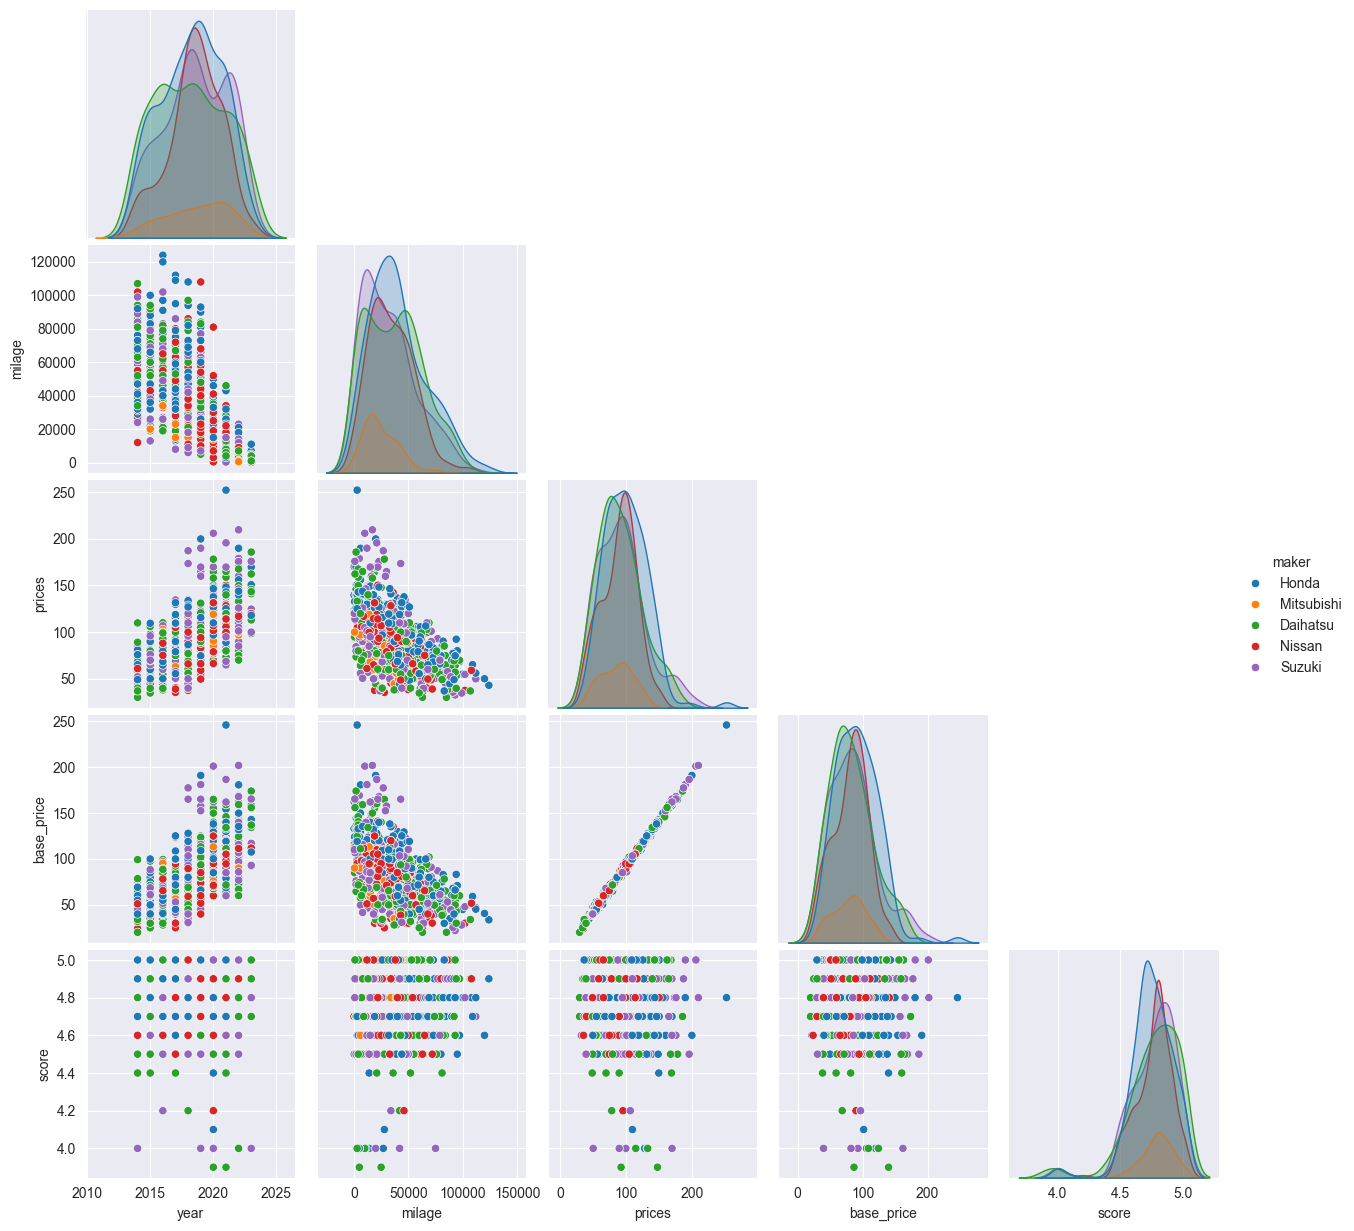

In [240]:

sns.pairplot(
    data=df.query("maker in @top5_maker and milage > 100 and score > 1").loc[:,["year","milage","prices","base_price","maker","score"]].sample(1000),
    corner=True,
    hue="maker"
)

#milage vs year - newer car has lower milage
#price vs year - newer car cost higher price
#most car score between 4.4-5.0, they are kept and maintained well
#some daihatsu car score below 4.0
#milage - price -

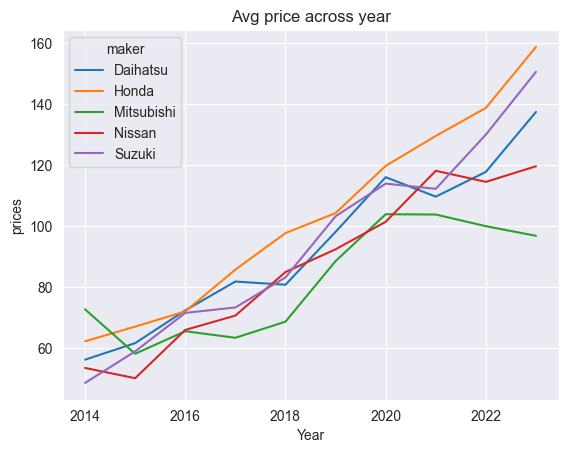

In [241]:
# average price of car by maker acros year

df_pivot_maker = (df
                  .query("maker in @top5_maker")
                  .pivot_table(
                        index="year",
                        values="prices",
                        columns="maker",
                        aggfunc="mean"
))
axes = df_pivot_maker.plot(
    xlabel="Year",
    ylabel="prices",
    title="Avg price across year"
)

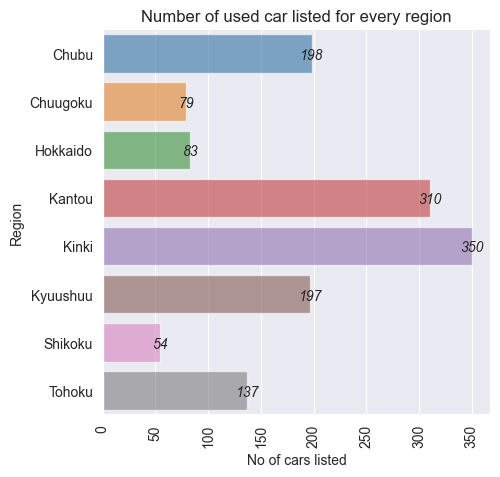

In [267]:
"""
As a whole, japan is divided into 8 areas, Hokkaido,Tohoku, Kantou, Chubu, Kinki, Chuukoku, Shikoku, Kyuushuu.
Analyse dominant car maker in each area.
"""
region = {
    "Hokkaido" : ["Hokkaido"],
    "Tohoku" : ["Aomori", "Iwate","Miyagi","Yamagata", "Fukushima"],
    "Kantou" : ["Saitama","Tochigi","Chiba","Kanagawa","Ibaraki","Gunma","Tokyo"],
    "Chubu" : ["Aichi", "Fukui", "Gifu", "Ishikawa", "Nagano", "Niigata", "Shizuoka", "Toyama","Yamanashi"],
    "Kinki" : ["Nara", "Wakayama", "Kyoto", "Osaka", "Hyōgo", "Shiga", "Mie"],
    "Chuugoku" : ["Hiroshima", "Okayama", "Shimane", "Tottori" , "Yamaguchi"],
    "Shikoku" : [ "Ehime", "Kagawa", "Kochi", "Tokushima"],
    "Kyuushuu" : ["Fukuoka", "Saga", "Nagasaki", "Oita", "Kumamoto", "Miyazaki", "Kagoshima", "Okinawa"]
}

def set_region(prefecture):
    for area, prefectures in region.items():
        if prefecture in prefectures:
            return area

df = df.assign(
    region = df["prefecture"].map(set_region)
)

fig, axes = plt.subplots(figsize = (5,5))

sns.barplot(
    y=df.groupby("region").agg("size").index,
    x=df.groupby("region").agg("size").values,
    hue=df.groupby("region").agg("size").index,
    ax=axes,
    alpha=0.6
)

for index, value in enumerate(df.groupby("region").agg("size")):
    axes.text(x=value, y=index, s=value, ha="center", va="center_baseline", fontstyle="oblique")

axes.set_xlabel("No of cars listed")
axes.set_ylabel("Region")
axes.set_title("Number of used car listed for every region")

plt.xticks(rotation=90)

plt.show()


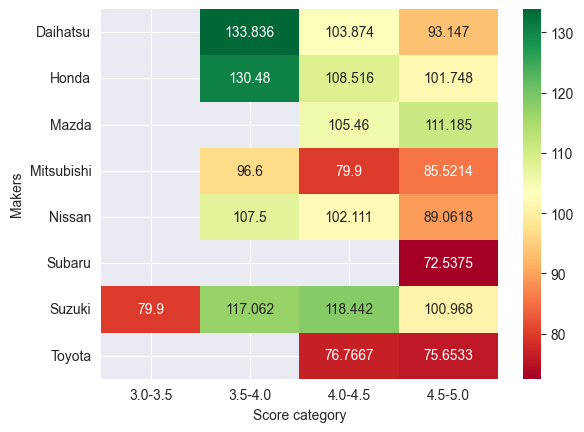

In [266]:
# Price average by score
sns.heatmap(
    (df.pivot_table(
    index="maker",
    columns="score_cat",
    values="prices",
    aggfunc="mean"
)),
annot=True,
cmap="RdYlGn",
fmt="g"
)
plt.ylabel("Makers")
plt.xlabel("Score category")
plt.show()

# On average, a daihatsu and honda with score category cost more than other maker

<Axes: title={'center': 'No of car listed across region'}, xlabel='Region', ylabel='Number of car listed'>

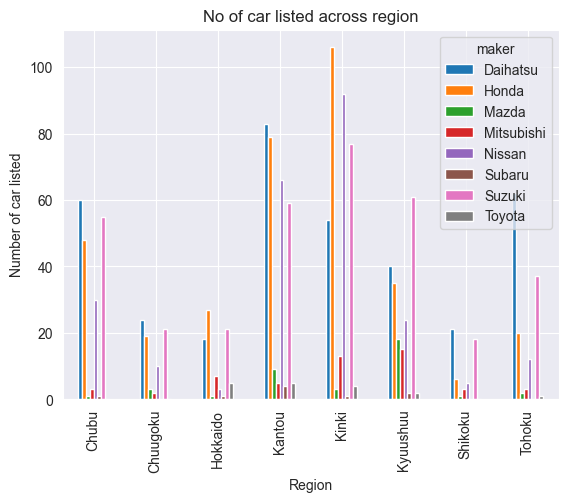

In [279]:
# Popular car model in each region
df.pivot_table(
    columns="maker",
    index="region",
    values="trim",
    aggfunc="count"
).plot.bar(
    title="No of car listed across region",
    xlabel="Region",
    ylabel="Number of car listed"
)

# across avery region, Honda, Daihatsu and suzuki dominates the used car market

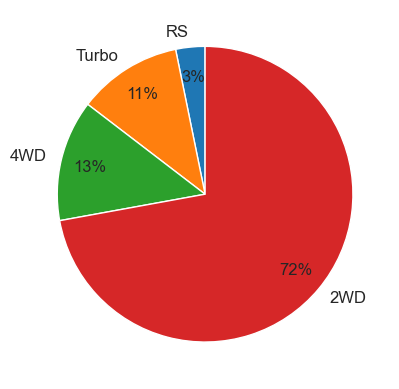

In [307]:
plt.pie(df.groupby("spec").size().sort_values(),
        startangle=90,
        pctdistance=0.80,
        autopct="%1.0f%%",
        textprops={ 'fontsize': 12},
        labels = df.groupby("spec").size().sort_values().index.tolist()
        )
# df.groupby("spec").size().sort_values().index
plt.show()

,maker,name,base_price,prices,spec,year,score,prefecture,trim,milage,color,permit_validity,repair_history,guarantee,engine_size,score_cat,region
1141,Suzuki,アルトラパン,79.1,88.0,4WD,2017,4.8,Niigata,hatchback,50000.0,Pearl Red,202403,No,Guarantee,660CC,4.5-5.0,Chubu


In [318]:
# A customer has a budget around 1 million yen. He is planning to buy a for daily use. As he live in a snowfall area,
# a 4wd might be a great choice for him. Maker does not really matter to him but to save money doing maintenace, 
# a car that still has a long permit validity will help him save more money.
# and he lives in Nagano, car dealer from Nagano, gifu or Niigata would be helpful to save distance 

closest_prefectures = ["Nagano","Niigata","Gifu","Toyama"]
(
df.query("spec == '4WD' and prices <= 100 and prefecture in @closest_prefectures")
.sort_values("year", ascending=False)
.loc[df["permit_validity"] != "Permit extension service"]
)

,maker,name,base_price,prices,spec,year,score,prefecture,trim,milage,color,permit_validity,repair_history,guarantee,engine_size,score_cat,region
1141,Suzuki,アルトラパン,79.1,88.0,4WD,2017,4.8,Niigata,hatchback,50000.0,Pearl Red,202403,No,Guarantee,660CC,4.5-5.0,Chubu


In [ ]:
# A 2017 suzuki Alto, with milage of 50000km. Cost 880000yen, and he can save 120000yen. Lcated in Niigata which is close prefecture 
# to his prefecture